In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level, then into utils
utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
# Add to sys.path
sys.path.append(utils_path)

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth
from bull_trend_regime_utils import load_bull_trend_data, create_advanced_bull_feat, merge_clean_final_clusters

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

In [3]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [4]:
df_bull_raw = load_bull_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

bull_features_df = create_advanced_bull_feat(df_bull_raw)

In [5]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [6]:
## If want to predict
# Load models
bull_scaler = joblib.load(os.path.join(MODEL_DIR, "bull_trend_scaler.pkl"))
bull_umap_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_umap_model.pkl"))
spectral_model = joblib.load(os.path.join(MODEL_DIR, "bull_trend_spectral_model.pkl"))

# scale data
bull_trend_scaled = bull_scaler.transform(only_bull_features_df)

# Apply UMAP transformation
bull_trend_umap = bull_umap_model.transform(bull_trend_scaled)

# Predict clusters, SpectralClustering doesn’t have a .predict() method for unseen data.
# Every time you call fit_predict(), it re-computes clusters from scratch, so for new data, you need to re-run it on all data (old + new)
bull_trend_spectral_labels = spectral_model.fit_predict(bull_trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(bull_trend_umap, bull_trend_spectral_labels))

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
# compute final clusters
df_final_clusters = merge_clean_final_clusters(bull_trend_spectral_labels, only_bull_features_df, df_with_clusters)

df_final_clusters.value_counts(normalize=True, dropna=False)

final_cluster
1                0.252178
0                0.238881
2                0.188904
3                0.176066
4                0.143971
Name: proportion, dtype: float64

In [8]:
tickers_to_trade = [
    "SPY",  # S&P 500 ETF
    "EFA",  # MSCI EAFE (Developed Markets ex-US) ETF
    "EEM",  # MSCI Emerging Markets ETF
    "TLT",  # 20+ Year Treasury Bond ETF
    "GLD",  # Gold ETF
    "USO",  # Crude Oil ETF
    "QQQ",  # Nasdaq 100 ETF
    "IWM"   # Russell 2000 ETF
]

df_trade_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=tickers_to_trade)

print("NAs: ", df_trade_raw.pivot(columns="symbol").isna().sum().sum())

NAs:  0


In [9]:
def add_sma_crossover(df, short_window, long_window, signal_name):
    """Buy when short SMA crosses above long SMA, sell when crosses below."""
    """Trend-following / Momentum"""
    df = df.copy()
    df['SMA_short'] = df['close'].rolling(short_window).mean()
    df['SMA_long'] = df['close'].rolling(long_window).mean()
    df[signal_name] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    return df.drop(columns=['SMA_short', 'SMA_long'])

def add_rsi(df, period, signal_name):
    """Buy when RSI < 30 (oversold), sell when RSI > 70 (overbought)."""
    """Mean reversion"""
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    df[signal_name] = np.where(df['RSI'] < 30, 1, np.where(df['RSI'] > 70, -1, 0)) # 65 35 for large periods maybe
    return df.drop(columns=['RSI'])


def add_bollinger_bands(df, window, num_std, signal_name):
    """Buy when price closes below lower band, sell when above upper band."""
    """Volatility breakout & Reversion"""
    df = df.copy()
    sma = df['close'].rolling(window).mean()
    rolling_std = df['close'].rolling(window).std()
    upper_band = sma + num_std * rolling_std
    lower_band = sma - num_std * rolling_std
    df[signal_name] = np.where(df['close'] < lower_band, 1, np.where(df['close'] > upper_band, -1, 0))
    return df

# ---- Apply all strategies ----
def add_all_strategies(df):
    df = add_sma_crossover(df, short_window=5, long_window=10, signal_name="S1_1_signal")
    df = add_sma_crossover(df, short_window=10, long_window=20, signal_name="S1_2_signal")
    df = add_sma_crossover(df, short_window=14, long_window=28, signal_name="S1_3_signal")
    df = add_rsi(df, period=7, signal_name="S2_1_signal")
    df = add_rsi(df, period=14, signal_name="S2_2_signal")
    df = add_rsi(df, period=21, signal_name="S2_3_signal")
    df = add_bollinger_bands(df, window=10, num_std=1, signal_name="S3_1_signal")
    df = add_bollinger_bands(df, window=20, num_std=1, signal_name="S3_2_signal")
    df = add_bollinger_bands(df, window=40, num_std=1.5, signal_name="S3_3_signal")
    return df

df_strats = add_all_strategies(df_trade_raw)

# How This Works
# Signals are numeric:
# 1 = long bias,
# -1 = short bias,
# 0 = neutral (for RSI & Bollinger).

# No lookahead bias in signal generation: All rolling and EMA operations use only past data.

# Drop helper columns so only S1_signal to S6_signal remain, ready for ML feature building.

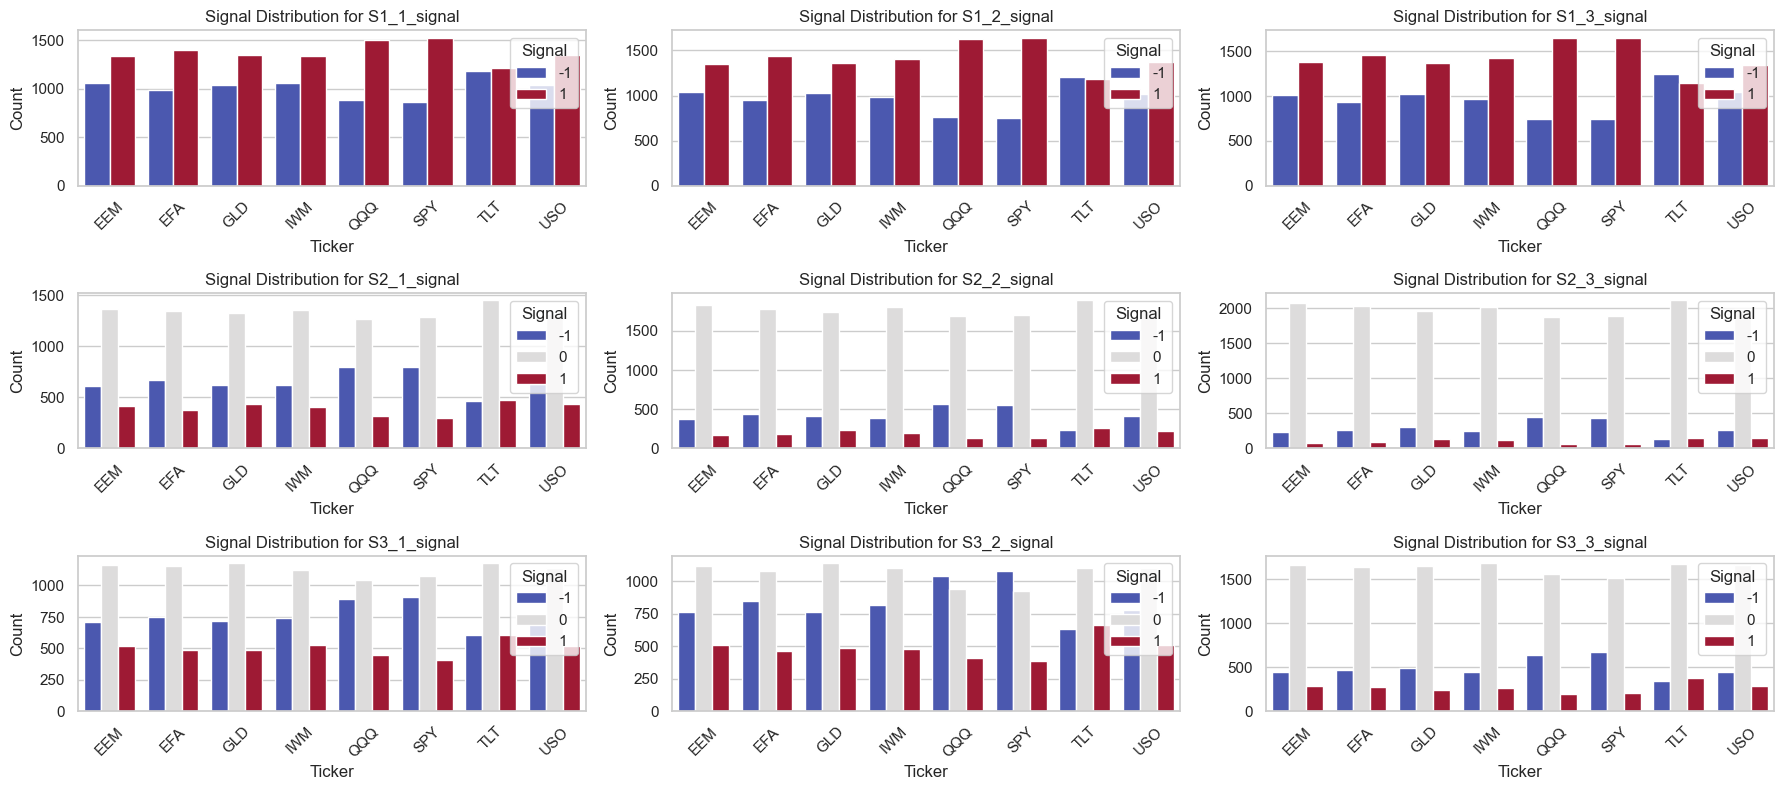

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_signal_distribution(df, signal_cols, symbol_col='symbol'):
    """
    Plots barplots showing distribution of signal values (1, 0, -1)
    per ticker and per strategy in a 3x2 subplot layout.
    """
    sns.set(style="whitegrid")
    
    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten to easily iterate
    
    for i, strat in enumerate(signal_cols):
        ax = axes[i]
        
        # Count frequency of each signal per ticker
        counts = (
            df.groupby(symbol_col)[strat]
            .value_counts()
            .unstack(fill_value=0)
            .reset_index()
            .melt(id_vars=symbol_col, var_name='Signal', value_name='Count')
        )
        
        # Plot on the corresponding subplot
        sns.barplot(data=counts, x=symbol_col, y='Count', hue='Signal', palette='coolwarm', ax=ax)
        
        ax.set_title(f"Signal Distribution for {strat}", fontsize=12)
        ax.set_xlabel("Ticker")
        ax.set_ylabel("Count")
        ax.legend(title="Signal")
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots if signal_cols < 6
    for j in range(len(signal_cols), 12):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

strategies = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]

plot_signal_distribution(df_strats, strategies)

In [11]:
HORIZON = 10

def compute_forward_returns(df, horizon=HORIZON):
    """
    For each symbol and timestamp, compute forward return over `horizon` days.
    Forward return = (close at t+horizon / close at t) - 1
    """
    df = df.copy()
    df['forward_return'] = df.groupby('symbol')['close'].shift(-horizon) / df['close'] - 1
    return df

def generate_strategy_returns(df, horizon=HORIZON):
    """
    For each strategy S1..S6, compute forward return assuming you go LONG when signal=1,
    SHORT when signal=-1, and 0 when neutral (signal=0).
    
    The strat_return per row per strategy is:
      forward_return * signal at current time
    
    Returns a DataFrame in long format:
      ['symbol', 'timestamp', 'strategy', 'signal', 'forward_return', 'strat_return']
    """
    df = df.copy()
    df = compute_forward_returns(df, horizon=horizon)
    
    strategy_cols = ["S1_1_signal", "S1_2_signal", "S1_3_signal", "S2_1_signal", "S2_2_signal", "S2_3_signal", "S3_1_signal", "S3_2_signal", "S3_3_signal"]
    records = []
    
    for strat in strategy_cols:
        temp = df[['symbol', 'close', strat, 'forward_return']].copy()
        temp = temp.rename(columns={strat: 'signal'})
        temp['strategy'] = strat
        
        # strat_return is forward return weighted by position signal
        # Long = profit if price rises, Short = profit if price falls
        temp['strat_return'] = temp['forward_return'] * temp['signal']
        
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to
        temp = temp[temp['signal'] != 0]
        
        records.append(temp[['symbol', 'strategy', 'signal', 'forward_return', 'strat_return']])
    
    df_strat_returns = pd.concat(records).reset_index()
    return df_strat_returns.set_index('timestamp')


df_return_strats = generate_strategy_returns(df_strats, horizon=HORIZON)

In [12]:
        ###### Optionally remove neutral signals to reduce noise
        # Neutral signals are safe to exclude if you want your model to focus on
        #  performance conditional on entering a trade. Keep them if you want 
        # the model to learn when to trade vs when not to

In [13]:
# shift clusters since they are computed at the end of the day, so that info is not available, drop frist day since is nan
shifted_regimes = df_final_clusters[["final_cluster"]].shift(1).dropna().astype(int)

# join with clusters (first months have no cluster so have to drop them)
df_joined = df_return_strats.join(shifted_regimes, how='inner')
df_joined.rename(columns={"final_cluster": "prev_regime"}, inplace=True)

df_joined.drop(columns="forward_return", inplace=True)
# drop last days without available returns
df_joined.dropna(subset=['strat_return'], inplace=True)

df_joined

,symbol,strategy,signal,strat_return,prev_regime
timestamp,,,,,
2016-11-14 05:00:00+00:00,EEM,S1_1_signal,-1,-0.033131,3
2016-11-15 05:00:00+00:00,EEM,S1_1_signal,-1,-0.015712,3
2016-11-16 05:00:00+00:00,EEM,S1_1_signal,-1,-0.013028,3
2016-11-17 05:00:00+00:00,EEM,S1_1_signal,-1,-0.010904,3
2016-11-18 05:00:00+00:00,EEM,S1_1_signal,-1,-0.022591,3
...,...,...,...,...,...
2025-06-13 04:00:00+00:00,USO,S3_3_signal,-1,0.088631,1
2025-06-16 04:00:00+00:00,USO,S3_3_signal,-1,0.059295,1
2025-06-17 04:00:00+00:00,USO,S3_3_signal,-1,0.081531,1


C:\Users\sergi\AppData\Local\Temp\ipykernel_13924\3722318940.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


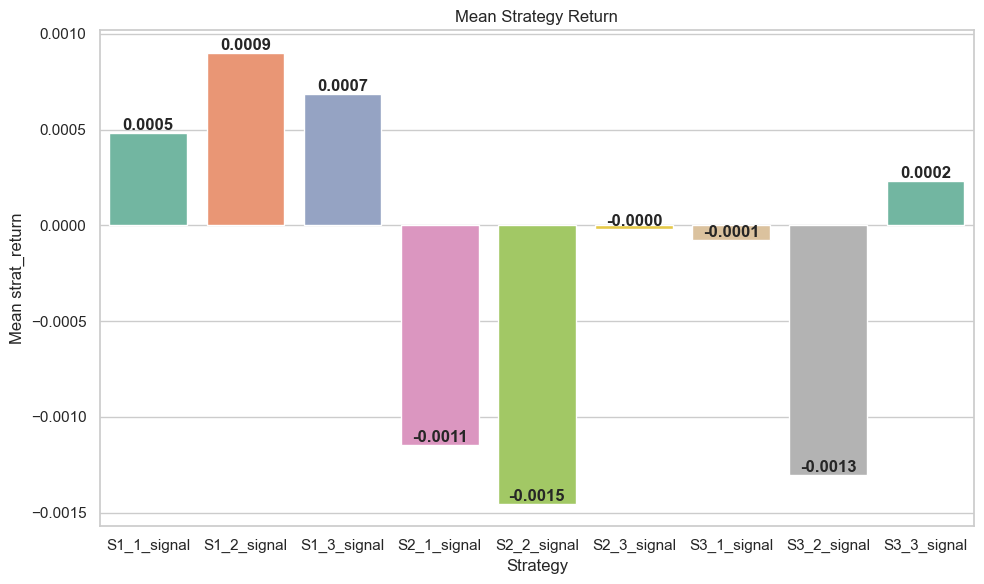

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_return_per_strategy(df):
    """
    Plot mean strat_return grouped only by strategy.
    """
    # Compute mean strat_return per strategy
    grouped = df.groupby('strategy')['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    # Create barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        palette='Set2'
    )

    plt.title('Mean Strategy Return')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')

    # Add value annotations on top of bars
    for i, row in grouped.iterrows():
        plt.text(i, row['strat_return'], f'{row["strat_return"]:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_return_per_strategy(df_joined)

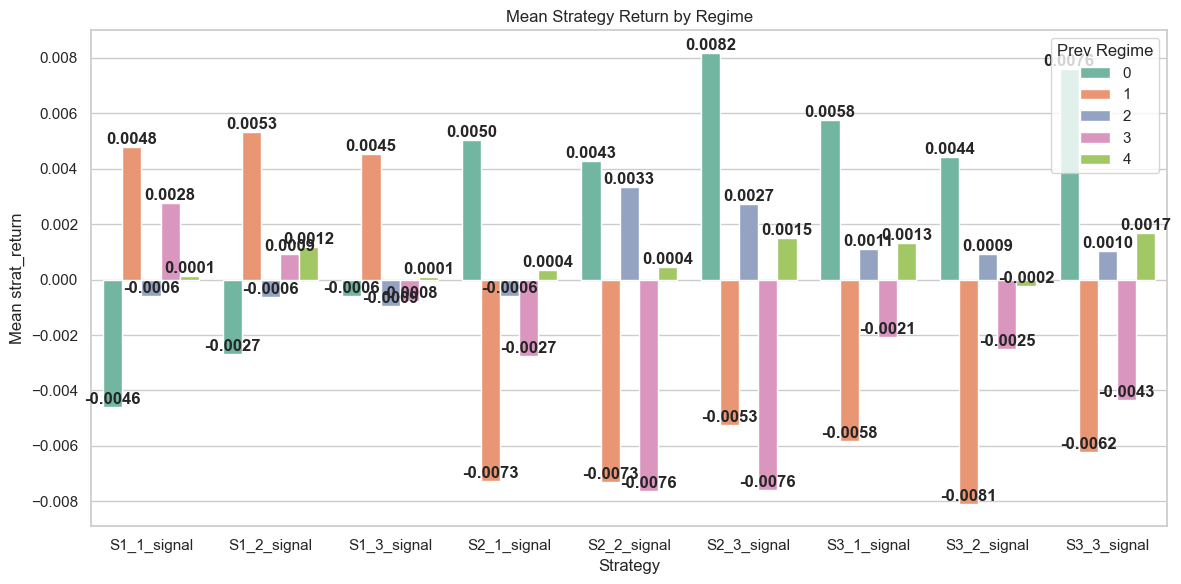

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_return_by_strategy_and_regime(df):
    """
    Plot mean strat_return grouped by strategy and prev_regime.
    """
    # Compute mean strat_return per strategy and regime
    grouped = df.groupby(['strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    # Create barplot with strategy on x-axis and hue=prev_regime
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped,
        x='strategy',
        y='strat_return',
        hue='prev_regime',
        palette='Set2'
    )

    plt.title('Mean Strategy Return by Regime')
    plt.xlabel('Strategy')
    plt.ylabel('Mean strat_return')
    plt.legend(title='Prev Regime')

    # Add value annotations on top of bars
    for i, bar in enumerate(plt.gca().patches):
        height = bar.get_height()
        if height:  # Avoid annotating empty bars
            plt.gca().text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.4f}',
                ha='center',
                va='bottom',
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_return_by_strategy_and_regime(df_joined)


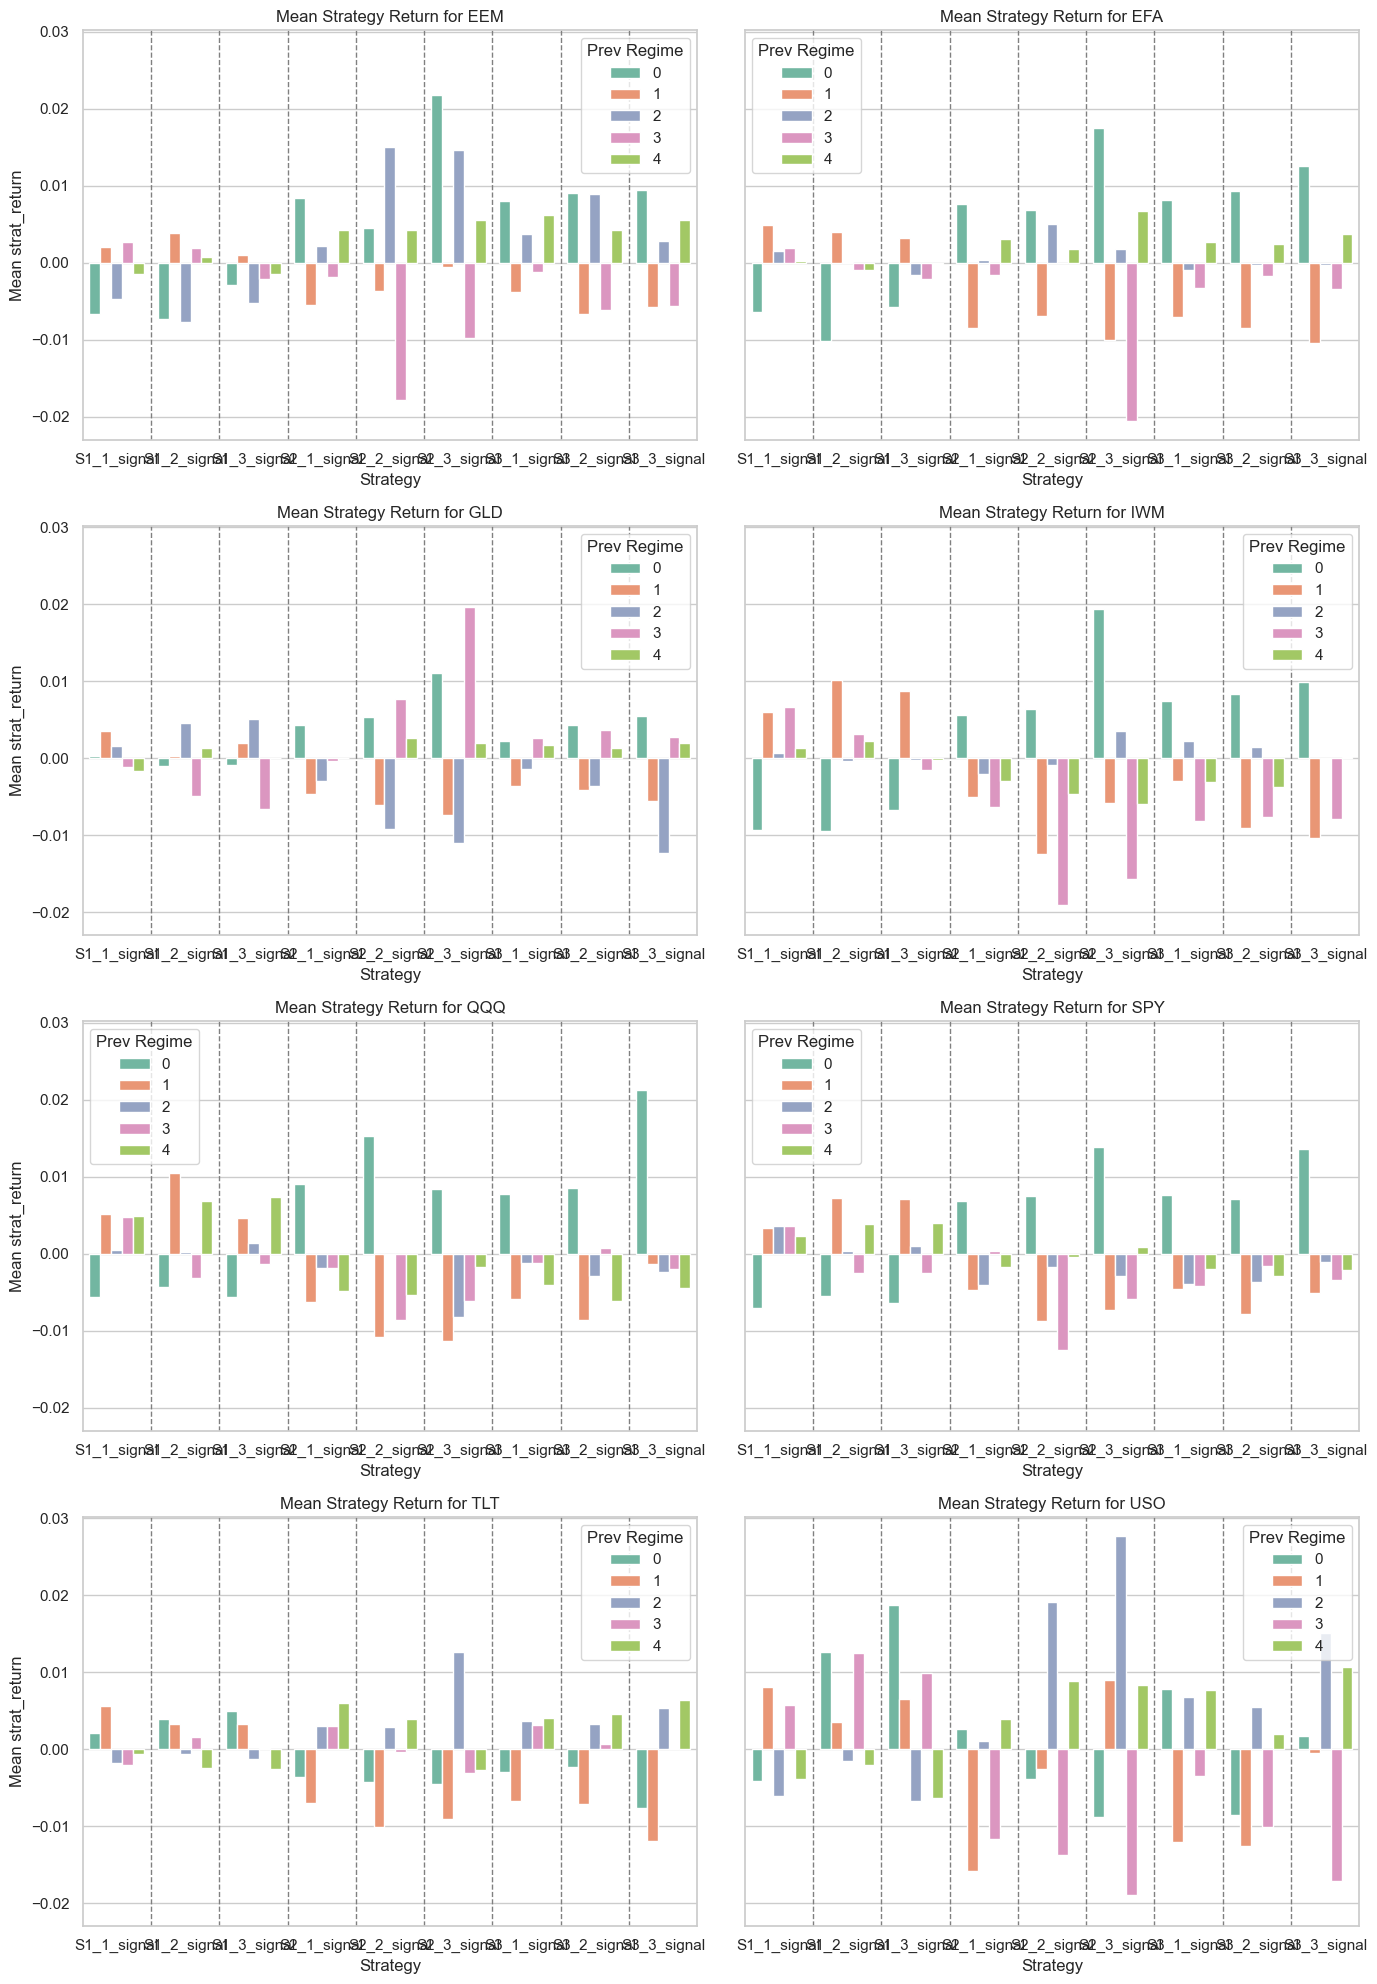

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_strat_return(df):
    """
    Plot mean strat_return grouped by symbol, strategy, and prev_regime.
    """
    # Compute mean strat_return
    grouped = df.groupby(['symbol', 'strategy', 'prev_regime'])['strat_return'].mean().reset_index()

    # Set seaborn style
    sns.set(style='whitegrid')

    symbols = grouped['symbol'].unique()
    n_symbols = len(symbols)

    # Create subplots, one per symbol (adjust cols and rows as needed)
    cols = 2
    rows = (n_symbols + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), sharey=True)
    axes = axes.flatten()

    for i, sym in enumerate(symbols):
        ax = axes[i]
        data = grouped[grouped['symbol'] == sym]

        # Draw barplot with strategy on x-axis, hue=prev_regime
        sns.barplot(
            data=data,
            x='strategy',
            y='strat_return',
            hue='prev_regime',
            ax=ax,
            palette='Set2'
        )

        ax.set_title(f'Mean Strategy Return for {sym}')
        ax.set_xlabel('Strategy')
        ax.set_ylabel('Mean strat_return')
        ax.legend(title='Prev Regime')

        # Add vertical delimiters between strategies
        # Strategies are categorical on x-axis, positions 0,1,2,...,n-1
        n_strategies = data['strategy'].nunique()
        for pos in range(0, n_strategies - 1):
            ax.axvline(pos + 0.5, color='gray', linestyle='--', linewidth=1)

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage:
plot_mean_strat_return(df_joined)

In [17]:
def add_features(df):
    df = df.copy()

    # 1. Returns
    df['return_1d'] = df['close'].pct_change(1)
    df['return_3d'] = df['close'].pct_change(3)
    df['return_5d'] = df['close'].pct_change(5)

    # # 2. Volatility (rolling std of returns)
    df['log_return_1d'] = np.log(df['close'] / df['close'].shift(1))
    df['vol_5d'] = df['log_return_1d'].rolling(window=5).std()
    df['vol_10d'] = df['log_return_1d'].rolling(window=10).std()
    df.drop(columns="log_return_1d",  inplace=True)

    # 3. Momentum (price relative to N-day ago)
    df['mom_5d'] = df['close'] / df['close'].shift(5) - 1
    df['mom_10d'] = df['close'] / df['close'].shift(10) - 1
    df['mom_20d'] = df['close'] / df['close'].shift(20) - 1

    # 4. Moving averages
    df['sma_5d'] = df['close'].rolling(window=5).mean()
    df['sma_10d'] = df['close'].rolling(window=10).mean()
    df['sma_20d'] = df['close'].rolling(window=20).mean()

    # 5. Price relative to moving averages
    df['price_div_sma5'] = df['close'] / df['close'].rolling(window=5).mean() - 1
    df['price_div_sma10'] = df['close'] / df['close'].rolling(window=10).mean() - 1
    df['price_div_sma20'] = df['close'] / df['close'].rolling(window=20).mean() - 1

    # 6. Volume features
    df['vol_rolling_5d'] = df['volume'].rolling(window=5).mean()
    df['vol_rolling_10d'] = df['volume'].rolling(window=10).mean()
    df['vol_rolling_20d'] = df['volume'].rolling(window=20).mean()

    # # 7. Volatility normalized by volume (volume volatility ratio)
    df['vol_vol_ratio_5d'] = df['vol_5d'] / (df['vol_rolling_5d'] + 1e-9)

    # # 8. Price range (High-Low) relative to close
    df['range_pct'] = (df['high'] - df['low']) / df['close']

    # # 9. ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['atr_7'] = tr.rolling(window=7).mean()
    df['atr_14'] = tr.rolling(window=14).mean()

    # # 10. Log volume change
    df['log_vol_change_1d'] = np.log(df['volume'] + 1) - np.log(df['volume'].shift(1) + 1)

    # Drop rows with NaNs due to rolling calculations
    df = df.dropna()

    return df.drop(columns=["open", "high", "low", "close", "volume", "trade_count", "vwap"])

# Example usage:
df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)

C:\Users\sergi\AppData\Local\Temp\ipykernel_13924\1525919639.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df_trade_raw.groupby('symbol', group_keys=False).apply(add_features)


In [18]:
RETURN_THRESHOLD = 0.005 # 0.99 = 99%

# join with previous dataset
# Set 'symbol' as part of the index
# Join on both index levels (timestamp and symbol)
final_df = df_features.set_index('symbol', append=True).join(df_joined.set_index('symbol', append=True), how='inner')

# back to column
final_df = final_df.reset_index(level='symbol')

# discretize the target, 1 if returns > RETURN_THRESHOLD
final_df["strat_return"] = np.where(final_df["strat_return"] >= RETURN_THRESHOLD, 1, 0)

final_df

,symbol,return_1d,return_3d,return_5d,vol_5d,vol_10d,mom_5d,mom_10d,mom_20d,sma_5d,...,vol_rolling_20d,vol_vol_ratio_5d,range_pct,atr_7,atr_14,log_vol_change_1d,strategy,signal,strat_return,prev_regime
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,87007315.8,9.885085e-11,0.013538,0.780000,0.594286,-0.535504,S1_1_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,87007315.8,9.885085e-11,0.013538,0.780000,0.594286,-0.535504,S1_2_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,87007315.8,9.885085e-11,0.013538,0.780000,0.594286,-0.535504,S1_3_signal,-1,0,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,87007315.8,9.885085e-11,0.013538,0.780000,0.594286,-0.535504,S2_2_signal,1,1,3
2016-11-14 05:00:00+00:00,EEM,-0.007777,-0.053927,-0.078766,0.015970,0.019238,-0.078766,-0.076645,-0.068988,29.102,...,87007315.8,9.885085e-11,0.013538,0.780000,0.594286,-0.535504,S3_1_signal,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02 04:00:00+00:00,USO,0.022454,0.031523,0.031101,0.010812,0.032015,0.031101,-0.081531,0.081557,73.900,...,15530295.7,1.424175e-09,0.033205,1.898571,2.949286,0.383175,S1_3_signal,1,1,4
2025-07-03 04:00:00+00:00,USO,-0.005292,0.028450,0.021742,0.012003,0.031914,0.021742,-0.086058,0.084367,74.220,...,15427274.0,1.827557e-09,0.013898,1.413571,2.905357,-0.390058,S1_1_signal,-1,0,4
2025-07-03 04:00:00+00:00,USO,-0.005292,0.028450,0.021742,0.012003,0.031914,0.021742,-0.086058,0.084367,74.220,...,15427274.0,1.827557e-09,0.013898,1.413571,2.905357,-0.390058,S1_2_signal,-1,0,4


In [19]:
final_df["strat_return"].value_counts(normalize=True)

strat_return
0    0.56908
1    0.43092
Name: proportion, dtype: float64

In [20]:
# We'll count forward, resetting when the regime changes
consecutive_days = []
count = 0
prev = None
for val in final_df['prev_regime']:
    if val == prev:
        count += 1
    else:
        count = 1  # start counting again
    consecutive_days.append(count)
    prev = val

final_df['consec_days_current_regime'] = consecutive_days

# Last previous regime different from current
last_diff_regime = []
for i, curr_regime in enumerate(final_df['prev_regime']):
    found = np.nan # if no prev regime
    for j in range(i-1, -1, -1):
        if final_df['prev_regime'].iloc[j] != curr_regime:
            found = final_df['prev_regime'].iloc[j]
            break
    last_diff_regime.append(found)

final_df['last_prev_regime_different'] = last_diff_regime

# Days since last occurrence for each regime
for regime_type in range(5):
    col_name = f"days_since_regime_{regime_type}"
    mask = final_df['prev_regime'] == regime_type
    
    last_seen_idx = None
    days_since = []
    
    for i, val in enumerate(final_df['prev_regime']):
        if val == regime_type:
            last_seen_idx = i
            days_since.append(0)
        else:
            if last_seen_idx is None:
                days_since.append(np.nan)  # NaN for never seen
            else:
                days_since.append(i - last_seen_idx)
    
    final_df[col_name] = days_since

final_df.dropna(inplace=True) # drop nan rows that generated with these columns

In [21]:
final_df.columns

Index(['symbol', 'return_1d', 'return_3d', 'return_5d', 'vol_5d', 'vol_10d',
       'mom_5d', 'mom_10d', 'mom_20d', 'sma_5d', 'sma_10d', 'sma_20d',
       'price_div_sma5', 'price_div_sma10', 'price_div_sma20',
       'vol_rolling_5d', 'vol_rolling_10d', 'vol_rolling_20d',
       'vol_vol_ratio_5d', 'range_pct', 'atr_7', 'atr_14', 'log_vol_change_1d',
       'strategy', 'signal', 'strat_return', 'prev_regime',
       'consec_days_current_regime', 'last_prev_regime_different',
       'days_since_regime_0', 'days_since_regime_1', 'days_since_regime_2',
       'days_since_regime_3', 'days_since_regime_4'],
      dtype='object')

In [22]:
# Global models hyperparameters
GLOBAL_LAYERS = [512, 256, 128, 64]
GLOBAL_DROPUT = 0.4
GLOBAL_LEARNING_RATE_OPTIMIZER = 5e-4
GLOBAL_LEARNING_RATE = 5e-4
GLOBAL_EPOCHS = 30
GLOBAL_BATCH_SIZE = 512

# Fine-tunining hyperparams
LAST_FROZEN_DENSE_LAYER = 1
FINE_TUNE_LEARNING_RATE = 5e-4
FINE_TUNE_EPOCHS = 20
FINE_TUNE_BATCH_SIZE = 256

# Others
K_FOLD=5
DENSE_ACTIVATION_FUNCTION = 'relu'

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, average_precision_score
import re 

# -----------------------------
# Prepare features
# -----------------------------
categ_feats = ['symbol', 'strategy', 'prev_regime', 'last_prev_regime_different']
target_col = 'strat_return'

# Identify numeric features (exclude target and 'signal')
exclude_cols = categ_feats + [target_col, 'signal']
numeric_feats = [col for col in final_df.columns if col not in exclude_cols]

prev_regime_values = sorted(final_df['prev_regime'].unique())

# -----------------------------
# Prepare categorical one-hot encodings (embeddings are not worth it since our cardinality <= 10)
# -----------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_full = ohe.fit_transform(final_df[categ_feats])

# Numeric features
X_num_full = final_df[numeric_feats].values

# Target
y = final_df[target_col].values

# -----------------------------
# Model Inputs
# -----------------------------
num_inp = Input(shape=(X_num_full.shape[1],), name="numeric_inp")
cat_inp = Input(shape=(X_cat_full.shape[1],), name="categorical_inp")

# -----------------------------
# Model architecture
# -----------------------------
x = Concatenate()([num_inp, cat_inp])

# dense layers with BN + Dropout
for units in GLOBAL_LAYERS:
    x = Dense(units, activation=DENSE_ACTIVATION_FUNCTION, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(GLOBAL_DROPUT)(x)

out = Dense(1, activation='sigmoid')(x)

global_model_template = Model(inputs=[num_inp, cat_inp], outputs=out)
global_model_template.compile(
    optimizer=Adam(learning_rate=GLOBAL_LEARNING_RATE_OPTIMIZER),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
)

In [24]:
global_model_template.layers

[<InputLayer name=numeric_inp, built=True>,
 <InputLayer name=categorical_inp, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Dense name=dense_4, built=True>]

In [25]:
# -----------------------------
# Walk-forward CV with PR AUC tracking
# -----------------------------
tscv = TimeSeriesSplit(n_splits=K_FOLD)

global_pr_aucs = []
global_y_val_total_pred_proba = []
global_y_val_total = []

regimes_pr_aucs = d = {k: [] for k in range(5)}
regimes_y_val_total_pred_proba = d = {k: [] for k in range(5)}
regimes_y_val_total = d = {k: [] for k in range(5)}

global_only_regimes_pr_aucs = d = {k: [] for k in range(5)}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_num_full)):
    print(f"\n=== Fold {fold+1} ===")

    ##### BASE GLOBAL MODEL TRAINING 
    # Fit scaler on training numeric features
    scaler = StandardScaler()
    X_num_train_scaled = scaler.fit_transform(X_num_full[train_idx])
    X_num_val_scaled   = scaler.transform(X_num_full[val_idx])
    
    # Slice categorical arrays
    cat_train = X_cat_full[train_idx]
    cat_val   = X_cat_full[val_idx]
    
    # Build fold-specific inputs
    X_train = [X_num_train_scaled, cat_train]
    X_val   = [X_num_val_scaled, cat_val]
    y_train = y[train_idx]
    y_val   = y[val_idx]
    
    # Fresh model per fold
    global_model = tf.keras.models.clone_model(global_model_template)
    global_model.compile(
        optimizer=Adam(learning_rate=GLOBAL_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    
    global_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=GLOBAL_EPOCHS,
        batch_size=GLOBAL_BATCH_SIZE,
        verbose=0
    )
    
    val_pr_auc = average_precision_score(y_val, global_model.predict(X_val).ravel())
    global_pr_aucs.append(val_pr_auc)
    print(f"  Global model PR AUC: {val_pr_auc:.4f}")

    global_y_val_total.extend(y_val)
    global_y_val_total_pred_proba.extend(global_model.predict(X_val).ravel())

    ######### 
    ######### REGIME FINE-TUNED
    for regime_value in prev_regime_values:
        print(f"\n # Fine-tuning for regime = {regime_value}")
        
        # filter folders for only regime data (inside same folds)
        train_mask = (final_df.iloc[train_idx]['prev_regime'].values == regime_value)
        val_mask   = (final_df.iloc[val_idx]['prev_regime'].values == regime_value)

        # Apply regime masks to numerical data
        X_num_train_filt = X_num_train_scaled[train_mask]
        X_num_val_filt   = X_num_val_scaled[val_mask]

        # Apply regime masks to categorical data
        cat_train_filt = cat_train[train_mask]
        cat_val_filt   = cat_val[val_mask]

        # Build regime-filtered inputs
        X_train_filt = [X_num_train_filt, cat_train_filt]
        X_val_filt   = [X_num_val_filt, cat_val_filt]
        y_train_filt = y_train[train_mask]
        y_val_filt   = y_val[val_mask]

        print(f"  Regime-filtered train rows: {len(y_train_filt)}, Orginal train fold rows: {len(y_train)}, in percentage: {round(len(y_train_filt)/len(y_train)*100, 1)}%")
        print(f"  Regime-filtered val rows: {len(y_val_filt)}, Orginal val fold rows: {len(y_val)}, in percentage: {round(len(y_val_filt)/len(y_val)*100, 1)}%")

        model_ft = tf.keras.models.clone_model(global_model)
        model_ft.set_weights(global_model.get_weights())

        # Freeze firsts dense blocks
        # for safer name matching
        for layer in model_ft.layers:
            # Freeze everything up to dense_n (n = LAST_FROZEN_DENSE_LAYER) dense_n included
            # starts with dense, then dense_1, until dense_n, all frozen
            # rest denses + their batchnorm / dropout are left trainable
            if 'dense' in layer.name:
                match = re.search(r'_(\d+)$', layer.name)
                if match and int(match.group(1)) <= LAST_FROZEN_DENSE_LAYER:
                    layer.trainable = False
            elif 'batch_normalization' or 'dropout' in layer.name:
                match = re.search(r'_(\d+)$', layer.name)
                if match and int(match.group(1)) <= LAST_FROZEN_DENSE_LAYER:
                    layer.trainable = False

            # Input layers (numeric_inp / categorical_inp / concatenate) don’t have weights, so trainable=True doesn’t matter.
        
        # Recompile the model for the changes to take effect during training
        model_ft.compile(
            optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
        )
        
        # Fine-tune
        model_ft.fit(
            X_train_filt, y_train_filt,
            validation_data=(X_val_filt, y_val_filt),
            epochs=FINE_TUNE_EPOCHS,
            batch_size=FINE_TUNE_BATCH_SIZE,
            verbose=0
        )
        
        # Predictions & PR curve for fine_tuned
        y_pred_proba = model_ft.predict(X_val_filt).ravel()
        pr_auc = average_precision_score(y_val_filt, y_pred_proba)
        
        print(f"\nFine_tuned for Regime {regime_value} PR AUC: {pr_auc:.4f}")

        # PR AUC for global model only for regime validation data
        global_regime_pr_auc = average_precision_score(y_val_filt, global_model.predict(X_val_filt).ravel())
        global_only_regimes_pr_aucs[regime_value].append(global_regime_pr_auc)
        print(f"Global model PR AUC only for regime values = {regime_value}: {global_regime_pr_auc:.4f}")
        
        regimes_pr_aucs[regime_value].append(pr_auc)
        regimes_y_val_total[regime_value].extend(y_val_filt)
        regimes_y_val_total_pred_proba[regime_value].extend(model_ft.predict(X_val_filt).ravel())

        # save model if last fold
        if fold == K_FOLD-1:
            global_model.save(f"regime_{regime_value}_model.h5")


print(f"\n*** Training Finished ***")
global_model.save("global_model.h5")

print(f"\n*** Base Gobal Model Average PR AUC: {np.mean(global_pr_aucs):.4f} ***")

for regime_value in prev_regime_values:
    print(f"\n*** Average PR AUC for fine-tuned model for regime {regime_value}: {np.mean(regimes_pr_aucs[regime_value]):.4f} ***")
    print(f"\n*** Average PR AUC for global model for regime {regime_value}: {np.mean(global_only_regimes_pr_aucs[regime_value]):.4f} ***")



=== Fold 1 ===
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
  Global model PR AUC: 0.4299
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step

 # Fine-tuning for regime = 0
  Regime-filtered train rows: 3839, Orginal train fold rows: 15224, in percentage: 25.2%
  Regime-filtered val rows: 3916, Orginal val fold rows: 15221, in percentage: 25.7%
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 0 PR AUC: 0.5240
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
Global model PR AUC only for regime values = 0: 0.4730
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step

 # Fine-tuning for regime = 1
  Regime-filtered train rows: 3810, Orginal train fold rows: 15224, in percentage: 25.0%
  Regime-filtered val rows: 3881, Orginal val fold rows: 15221, in percentage: 25.5%
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 1 PR AUC: 0.4046
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Global model PR AUC only for regime values = 1: 0.4098
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 # Fine-tuning for 


 # Fine-tuning for regime = 1
  Regime-filtered train rows: 19058, Orginal train fold rows: 76108, in percentage: 25.0%
  Regime-filtered val rows: 4048, Orginal val fold rows: 15221, in percentage: 26.6%
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 1 PR AUC: 0.5114
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Global model PR AUC only for regime values = 1: 0.5113
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step



 # Fine-tuning for regime = 2
  Regime-filtered train rows: 13480, Orginal train fold rows: 76108, in percentage: 17.7%
  Regime-filtered val rows: 2866, Orginal val fold rows: 15221, in percentage: 18.8%
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 2 PR AUC: 0.5523
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Global model PR AUC only for regime values = 2: 0.5655
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



 # Fine-tuning for regime = 3
  Regime-filtered train rows: 12486, Orginal train fold rows: 76108, in percentage: 16.4%
  Regime-filtered val rows: 2905, Orginal val fold rows: 15221, in percentage: 19.1%
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 3 PR AUC: 0.5121
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Global model PR AUC only for regime values = 3: 0.5169
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



 # Fine-tuning for regime = 4
  Regime-filtered train rows: 12645, Orginal train fold rows: 76108, in percentage: 16.6%
  Regime-filtered val rows: 1872, Orginal val fold rows: 15221, in percentage: 12.3%
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fine_tuned for Regime 4 PR AUC: 0.4779
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Global model PR AUC only for regime values = 4: 0.4569
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



*** Training Finished ***



*** Base Gobal Model Average PR AUC: 0.5010 ***

*** Average PR AUC for fine-tuned model for regime 0: 0.5935 ***

*** Average PR AUC for global model for regime 0: 0.5459 ***

*** Average PR AUC for fine-tuned model for regime 1: 0.5145 ***

*** Average PR AUC for global model for regime 1: 0.4944 ***

*** Average PR AUC for fine-tuned model for regime 2: 0.4713 ***

*** Average PR AUC for global model for regime 2: 0.4709 ***

*** Average PR AUC for fine-tuned model for regime 3: 0.4965 ***

*** Average PR AUC for global model for regime 3: 0.4693 ***

*** Average PR AUC for fine-tuned model for regime 4: 0.5003 ***

*** Average PR AUC for global model for regime 4: 0.4922 ***


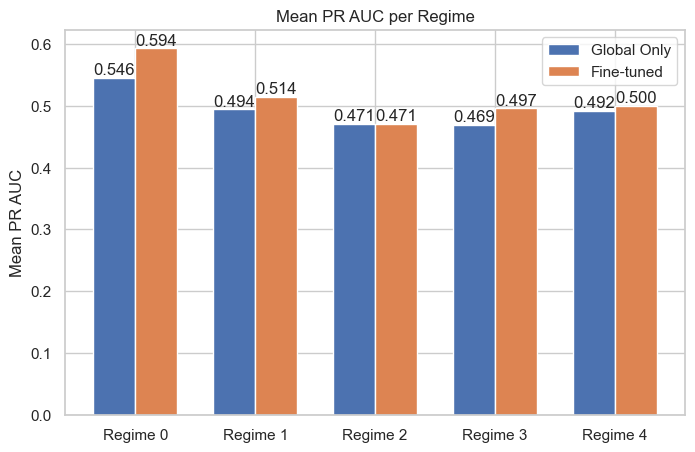

In [26]:
# Compute means
regimes = list(global_only_regimes_pr_aucs.keys())
means_global = [np.mean(global_only_regimes_pr_aucs[r]) for r in regimes]
means_finetune = [np.mean(regimes_pr_aucs[r]) for r in regimes]

# Bar positions
x = np.arange(len(regimes))
width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, means_global, width, label="Global Only")
bars2 = plt.bar(x + width/2, means_finetune, width, label="Fine-tuned")

plt.ylabel("Mean PR AUC")
plt.title("Mean PR AUC per Regime")
plt.xticks(x, [f"Regime {r}" for r in regimes])
plt.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height(),
                 f"{bar.get_height():.3f}",
                 ha='center', va='bottom')

plt.show()

In [27]:
import winsound

# Play a simple beep
winsound.Beep(frequency=700, duration=1000)  # frequency in Hz, duration in ms
winsound.Beep(frequency=500, duration=800)  # frequency in Hz, duration in ms
winsound.Beep(frequency=300, duration=600)  # frequency in Hz, duration in ms

In [28]:
def plot_rc_auc(y_val_total, y_val_total_pred_proba, regime_value=False, fold=False):
    pr_auc = average_precision_score(y_val_total, y_val_total_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val_total, y_val_total_pred_proba)
    
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if regime_value == False and fold != False:
        plt.title(f'Precision–Recall Curve\nGlobal - Fold {fold+1}')
    if regime_value != False and fold != False:
        plt.title(f'Precision–Recall Curve\nRegime {regime_value} - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()